## Gerekli Kütüphanelerin Yüklenmesi

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

## Veri Setinin Yüklenmesi ve Ön bakış

In [2]:
data = pd.read_csv('archive/superStoreDB.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### info #####################")
    print(dataframe.info())
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### MissingValues #####################")
    print(dataframe.isnull().sum())

In [5]:
check_df(data)

##################### Shape #####################
(9994, 21)
##################### Types #####################
Row_ID            int64
Order_ID         object
Order_Date       object
Ship_Date        object
Ship_Mode        object
Customer_ID      object
Customer_Name    object
Segment          object
Country          object
City             object
State            object
Postal_Code       int64
Region           object
Product_ID       object
Category         object
Sub_Category     object
Product_Name     object
Sales            object
Quantity          int64
Discount         object
Profit           object
dtype: object
##################### info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Row_ID         9994 non-null   int64 
 1   Order_ID       9994 non-null   object
 2   Order_Date     9994 non-null   object


## Veri Ön İşleme

In [6]:

# Tarih ve satış sütunlarının düzenlenmesi
data['Order_Date'] = pd.to_datetime(data['Order_Date'], errors='coerce')
data['Sales'] = data['Sales'].replace(',', '.', regex=True).astype(float)


In [7]:
data['Order_Date'].min()

Timestamp('2014-01-03 00:00:00')

In [8]:
data['Order_Date'].max()

Timestamp('2017-12-30 00:00:00')

In [9]:
# Haftalık satışların toplam olarak gruplandırılması
weekly_sales = data.set_index('Order_Date').resample('W').sum()['Sales']

In [10]:
# Verinin normalleştirilmesi
scaler = MinMaxScaler(feature_range=(0, 1))
weekly_sales_scaled = scaler.fit_transform(weekly_sales.values.reshape(-1, 1))

## Modelleme

In [11]:
# LSTM İçin Girdi Çıktı Oluşturma
sequence_length = 104  # 104 haftalık geçmişe bakarak tahmin yapacağız
X, y = [], []
for i in range(sequence_length, len(weekly_sales_scaled)):
    X.append(weekly_sales_scaled[i-sequence_length:i, 0])
    y.append(weekly_sales_scaled[i, 0])

In [12]:
# Numpy array formatına çevirme
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [13]:
# LSTM Modelini Tanımlama
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Modeli Derleme
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
# Modeli Eğitme
history = model.fit(X, y, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1110
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0464
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0385
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0422
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0354
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0390
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0376
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0385
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0337
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0337
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0356
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0387
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0288
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0374
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0348
Epoch 16/100
7/7 ━━

In [16]:
# Tahminlerin Yapılması
predictions = model.predict(X)
predictions_inverse = scaler.inverse_transform(predictions)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


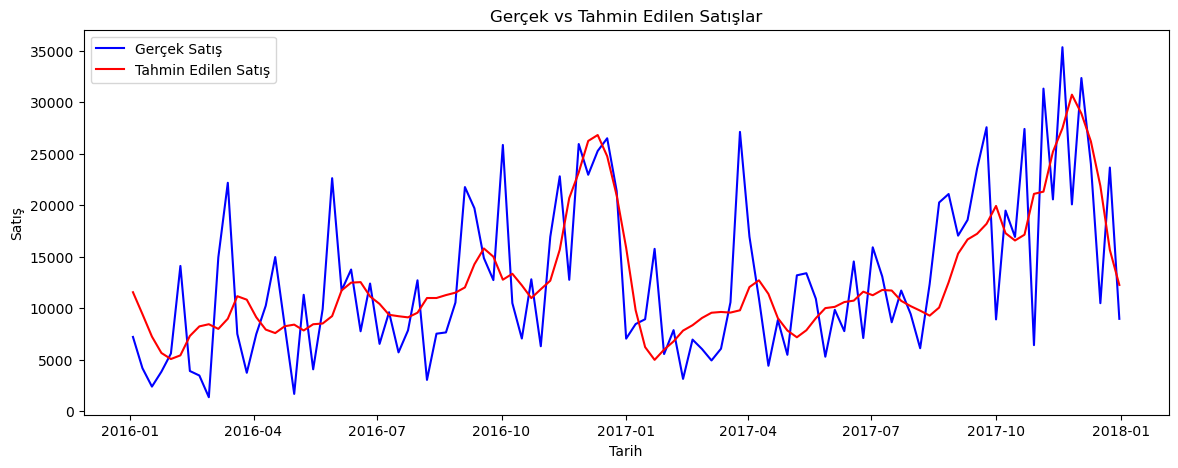

In [17]:
# Sonuçların Görselleştirilmesi
plt.figure(figsize=(14, 5))
plt.plot(weekly_sales.index[sequence_length:], scaler.inverse_transform(weekly_sales_scaled[sequence_length:]), color='blue', label='Gerçek Satış')
plt.plot(weekly_sales.index[sequence_length:], predictions_inverse, color='red', label='Tahmin Edilen Satış')
plt.title('Gerçek vs Tahmin Edilen Satışlar')
plt.xlabel('Tarih')
plt.ylabel('Satış')
plt.legend()
plt.show()

## Tahminleme

In [18]:
# Geleceğe Yönelik Tahminleme
future_weeks = 8  # 8 Haftalık İleriye yönelik 8 hafta tahminleme yapılması
input_sequence = weekly_sales_scaled[-sequence_length:]  # Modelin son gördüğü veriler
predicted_sales = []

for _ in range(future_weeks):
    # Modeli kullanarak tahminleme yapılması
    predicted_value = model.predict(input_sequence.reshape(1, sequence_length, 1))
    predicted_sales.append(predicted_value[0, 0])
    input_sequence = np.append(input_sequence[1:], predicted_value)[-sequence_length:]

# Tahmin edilen değerleri ters ölçeklendirme
predicted_sales = scaler.inverse_transform(np.array(predicted_sales).reshape(-1, 1))

# Gelecek haftalara tarih ekleme
last_date = weekly_sales.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(weeks=1), periods=future_weeks, freq='W')

# Gelecek tahmin sonuçlarını bir DataFrame olarak kaydetme
future_predictions_df = pd.DataFrame({'Date': future_dates, 'Weekly Sales Prediction': predicted_sales.flatten()})
future_predictions_df.to_csv('future_sales_predictions.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


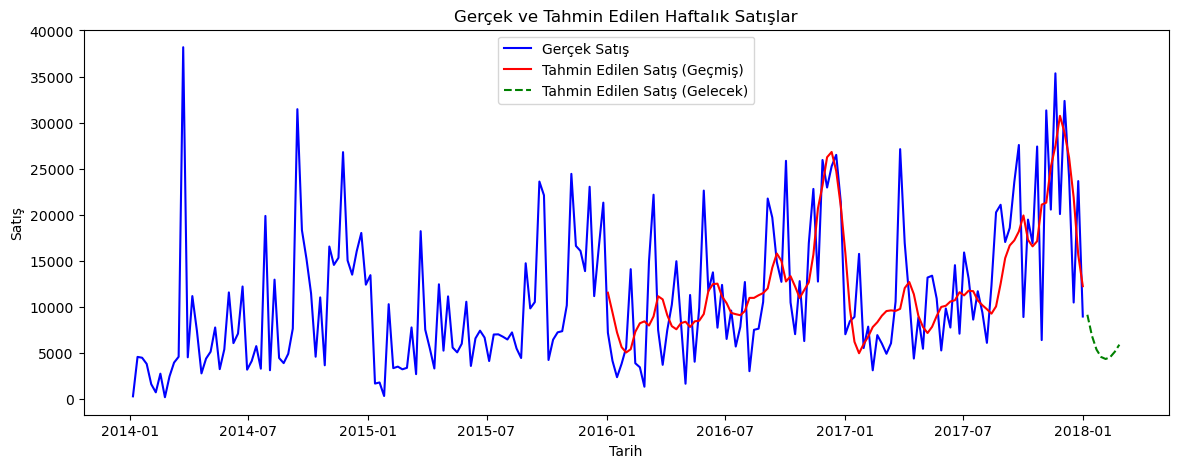

In [19]:
# Gerçek verilerin ve modelin tahmin ettiği geçmiş verilerin hazırlanması
plt.figure(figsize=(14, 5))
plt.plot(weekly_sales.index, scaler.inverse_transform(weekly_sales_scaled), color='blue', label='Gerçek Satış')
plt.plot(weekly_sales.index[sequence_length:], predictions_inverse, color='red', label='Tahmin Edilen Satış (Geçmiş)')

# Gelecek haftalar için tahmin edilen verilerin eklenmesi
plt.plot(future_dates, predicted_sales, color='green', linestyle='dashed', label='Tahmin Edilen Satış (Gelecek)')

# Grafik ayarlamaları
plt.title('Gerçek ve Tahmin Edilen Haftalık Satışlar')
plt.xlabel('Tarih')
plt.ylabel('Satış')
plt.legend()
plt.show()


In [20]:
# PowerBI Raporlaması için Mevcut ve Gelecek Tahmin Sonuçlarını Kaydetme
prediction_df = pd.DataFrame(predictions_inverse, columns=['Weekly Sales Prediction'])
prediction_df['Date'] = weekly_sales.index[sequence_length:]
prediction_df.to_csv('weekly_sales_predictions.csv', index=False)